In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-04_03-03_20180601_20191231_th60_per12_sm10.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

NQ       0.25
ES       0.25
GC       0.25
YM       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    10793.00
GC     7906.04
NQ    31457.20
YM    29339.60
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

79495.84

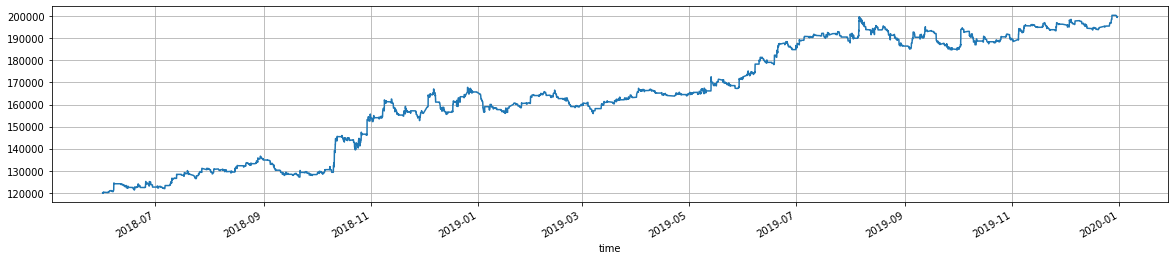

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     671
 GC    1139
 NQ    2068
 YM     624
 Name: action, dtype: int64,
 4502)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.628641
 GC    2.764563
 NQ    5.019417
 YM    1.514563
 Name: action, dtype: float64,
 10.927184466019417)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1409.10
GC    2756.38
NQ    4342.80
YM    1310.40
Name: commission, dtype: float64

In [15]:
df.commission.sum()

9818.68

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,13.89,446.19,-266.78,1.67,11.28,569.0
NQ,0.40,30.42,453.46,-248.66,1.82,32.19,1034.0
ES,0.39,32.22,879.42,-498.31,1.76,39.00,335.0
YM,0.39,94.04,776.65,-350.21,2.22,89.27,312.0
total,0.39,35.33,558.39,-305.06,1.83,31.69,2250.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.042337,0.242021,0.395716,0.729460
GC,0.042337,1.000000,0.061099,0.030261,0.372802
NQ,0.242021,0.061099,1.000000,0.206289,0.653978
YM,0.395716,0.030261,0.206289,1.000000,0.669500
total,0.729460,0.372802,0.653978,0.669500,1.000000


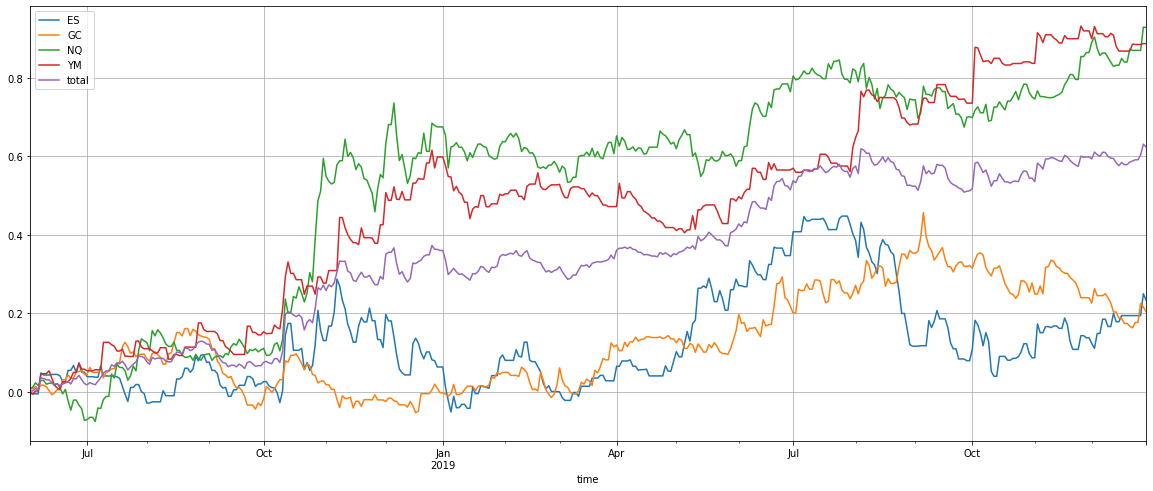

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

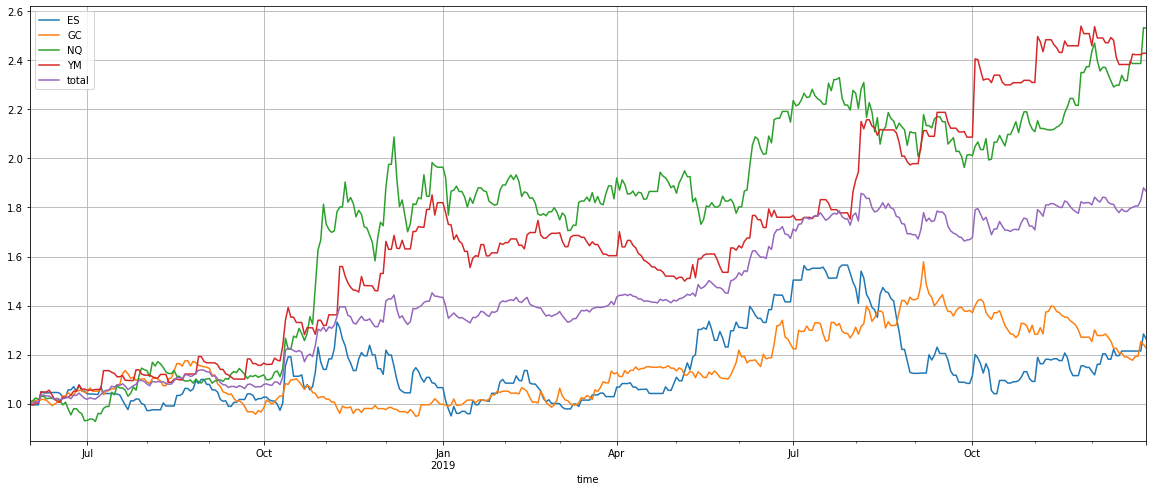

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.153471,0.132867,0.764901,0.720969,0.464636
Cumulative returns,0.262921,0.226248,1.531444,1.429240,0.866187
Annual volatility,0.397851,0.271521,0.384474,0.337859,0.218179
Sharpe ratio,0.553100,0.593659,1.668148,1.770518,1.857181
Calmar ratio,0.457872,0.522325,4.127836,3.795519,4.437197
Stability,0.271389,0.602531,0.791694,0.904798,0.925436
Max drawdown,-0.335184,-0.254376,-0.185303,-0.189953,-0.104714
Omega ratio,1.122551,1.114843,1.372596,1.560742,1.444205
Sortino ratio,0.968147,0.989804,2.911595,4.212244,3.721679
Skew,1.385241,0.874692,0.881314,2.830386,1.981284


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,5.12,4.54,-7.01,5.93,2.12
2018-07-31,-5.26,5.32,22.44,5.35,6.81
2018-08-31,8.27,4.31,-3.34,4.50,3.56
2018-09-30,-5.39,-15.95,1.08,-0.87,-5.39
2018-10-31,11.69,6.53,63.00,14.10,22.81
2018-11-30,-1.75,-4.76,-4.84,16.05,1.51
2018-12-31,-4.84,1.84,13.84,18.87,7.61
2019-01-31,3.14,5.33,-3.70,-9.37,-1.03
2019-02-28,-8.91,-3.33,-5.87,2.77,-3.76


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        26.0
GC        23.0
NQ       153.0
YM       143.0
total     87.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2018-11-08 16:26:00,YM,SELL,26156.00,5000.8
2019-10-02 20:43:00,YM,BUY,26058.00,4590.8
2018-10-11 04:23:00,ES,BUY,2766.50,4245.8
2019-05-13 16:32:30,ES,BUY,2817.75,3283.3
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
...,...,...,...,...
2018-12-19 20:00:00,ES,BUY,2592.25,-1316.7
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-10-11,0.151940,0.049021,0.108160,0.085080,0.098550
2019-10-02,0.076943,0.021355,0.018967,0.153027,0.067573
2018-12-03,0.088193,-0.003989,0.090747,0.085527,0.065119
2019-08-05,0.093470,0.023516,0.035793,0.106360,0.064785
2018-10-29,0.091110,-0.018656,0.101773,0.044693,0.054730
...,...,...,...,...,...
2019-09-18,-0.022223,-0.018656,-0.042393,-0.018973,-0.025562
2018-12-10,-0.035280,-0.008656,-0.061173,-0.000780,-0.026472
2018-10-22,-0.052363,-0.015656,-0.021920,-0.037113,-0.031763
